# Outlier Detection - Using AutoARIMA algorithm

This module provides an overview of the Outlier detection process using a time-series forecasting
algorithm known as AutoARIMA. The example provided here is of a univariate anomaly detection process.


### 1. Loading the Libraries and utility Functions


In [1]:
# Importing Essential Libraries
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.cluster import KMeans
from sktime.forecasting.arima import AutoARIMA


def infer_frequency(df_index, attempts=5):
    """Utility Function to detect the frequency of the time-series data"""
    if not isinstance(df_index, pd.DatetimeIndex):
        df_index = pd.to_datetime(df_index)
    if len(df_index) < 3:
        return "D"
    freq_dict = {"D": 0, "M": 0, "Y": 0}
    for _ in range(attempts):
        random_idx = random.randint(0, len(df_index) - 2)
        days_diff = (df_index[random_idx + 1] - df_index[random_idx]).days
        if days_diff < 28:
            freq_dict["D"] += 1
        elif days_diff <= 31:
            freq_dict["M"] += 1
        elif days_diff > 300 and days_diff <= 366:
            freq_dict["Y"] += 1
        else:
            freq_dict["D"] += 1
    return max(freq_dict, key=lambda k: freq_dict.get(k, 0))

### 2. Loading the Dataset


In [2]:
dataset = pd.read_csv("personal_expense_dataset.csv")
dataset.head()

,uid,name,dob,age,gender,state,region,country,datadate,Category,Payment Method,Location,Expense
0,ACC-59b11,Joel Berg,09-02-1994,30,Male,Chhattisgarh,Central Region,India,01-01-2022,Education,UPI,Gas Station,2061.13
1,ACC-59b11,Joel Berg,09-02-1994,30,Male,Chhattisgarh,Central Region,India,02-01-2022,Clothing,Bank Transfer,Restaurant,2500.26
2,ACC-59b11,Joel Berg,09-02-1994,30,Male,Chhattisgarh,Central Region,India,03-01-2022,Miscellaneous,Credit Card,Restaurant,4761.27
3,ACC-59b11,Joel Berg,09-02-1994,30,Male,Chhattisgarh,Central Region,India,04-01-2022,Miscellaneous,Credit Card,Home,183.13
4,ACC-59b11,Joel Berg,09-02-1994,30,Male,Chhattisgarh,Central Region,India,05-01-2022,Health & Fitness,Bank Transfer,Home,492.80


### 3. Dataset Pre-processing and Conversion into Time-series data


In [3]:
# Performing analysis for a random selected region
dataset["datadate"] = dataset["datadate"].apply(
    lambda x: datetime.datetime.strptime(x, "%d-%m-%Y")
)
region = random.choice(dataset["region"].unique())
time_series_data = (
    dataset[dataset["region"] == region].groupby("datadate")["Expense"].agg("mean")
)
time_series_data.name = "metric"
frequency = pd.infer_freq(time_series_data.index)
if frequency is None:
    frequency = infer_frequency(time_series_data.index)
time_series_data = time_series_data.asfreq("D").ffill().asfreq(frequency)

### 4. Fitting the AutoARIMA model on the dataset and predicting the upper and lower bounds


In [4]:
model = AutoARIMA(suppress_warnings=True)
predictions = model.fit_predict(time_series_data, fh=time_series_data.index)
predictions.name = "prediction"
intervals = model.predict_interval()
intervals.columns = intervals.columns.get_level_values(2)
output = pd.concat([time_series_data, predictions, intervals], axis=1)
output["outlier"] = output.apply(
    lambda x: x["metric"] >= x["upper"] or x["metric"] <= x["lower"], axis=1
)

### 5. Plotting the data and outliers using Matplotlib


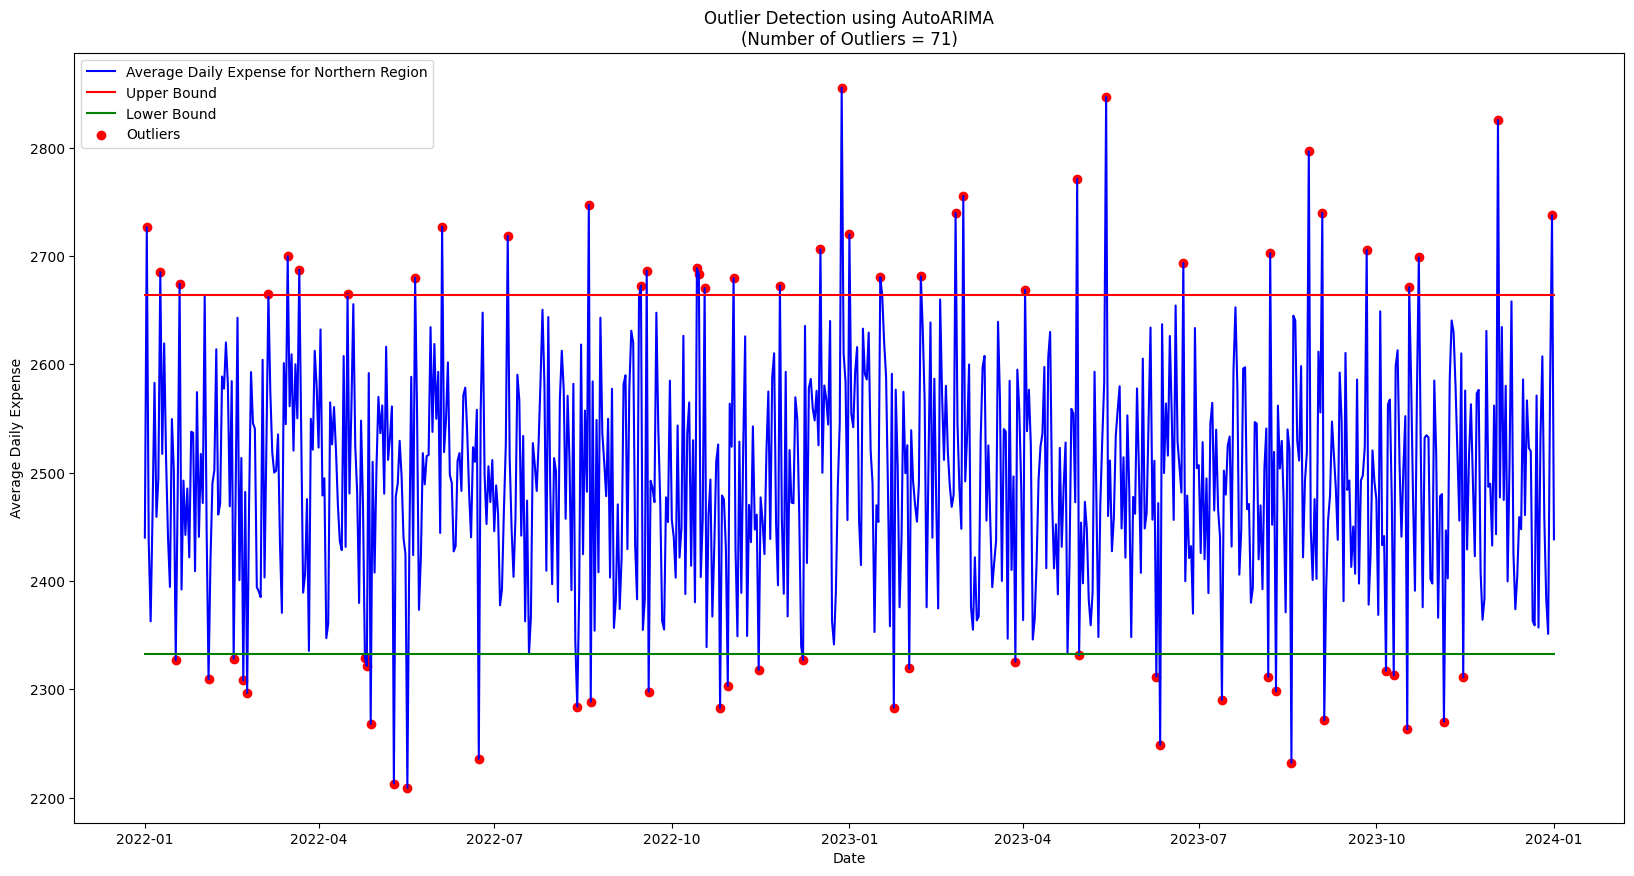

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(
    output.index,
    output["metric"],
    label=f"Average Daily Expense for {region}",
    color="blue",
)
plt.plot(output.index, output["upper"], label="Upper Bound", color="red")
plt.plot(output.index, output["lower"], label="Lower Bound", color="green")
plt.scatter(
    output[output["outlier"]].index,
    output[output["outlier"]]["metric"],
    label="Outliers",
    color="red",
)
plt.title(
    f"Outlier Detection using AutoARIMA\n(Number of Outliers = {len(output[output['outlier']])})"
)
plt.legend()
plt.xlabel("Date")
plt.ylabel("Average Daily Expense")
plt.show()

### 6. Generating interactive graphs using Plotly


In [6]:
trace1 = go.Scatter(
    x=output.index,
    y=output["metric"],
    mode="lines",
    name=f"Average Daily Expense for {region}",
    line=dict(color="blue"),
)
trace2 = go.Scatter(
    x=output.index,
    y=output["upper"],
    mode="lines",
    name="Upper Bound",
    line=dict(color="red"),
)
trace3 = go.Scatter(
    x=output.index,
    y=output["lower"],
    mode="lines",
    name="Lower Bound",
    line=dict(color="green"),
)
outlier_indices = output[output["outlier"]].index
trace4 = go.Scatter(
    x=outlier_indices,
    y=output.loc[outlier_indices, "metric"],
    mode="markers",
    name="Outliers",
    marker=dict(color="red", size=10),
)
layout = go.Layout(
    title=f"Outlier Detection using AutoARIMA\n(Number of Outliers = {len(output[output['outlier']])})",
    xaxis=dict(
        title="Date",
        rangeselector=dict(
            buttons=list(
                [
                    dict(count=1, label="1m", step="month", stepmode="backward"),
                    dict(count=6, label="6m", step="month", stepmode="backward"),
                    dict(count=1, label="1y", step="year", stepmode="backward"),
                    dict(step="all"),
                ]
            )
        ),
        rangeslider=dict(visible=True),
        type="date",
    ),
    yaxis=dict(title="Average Daily Expense"),
    template="plotly_white",  # Change the theme to light (plotly_white)
)
fig = go.Figure(data=[trace1, trace2, trace3, trace4], layout=layout)
fig.update_layout(width=1100, height=600)
fig.show()